**Cell 1: Imports and Configuration**

In [1]:
import pandas as pd
import numpy as np
import io
import re
import nltk
import torch
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import random
import time
import os

**Cell 2: Install Required Libraries**

In [2]:
!pip install networkx
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attemp

**Cell 3: Define File Paths**

In [3]:
PATH_EDGELIST = '/kaggle/input/nlp-cse-uoi-2025/data_new/edgelist.txt'
PATH_AUTHORS = '/kaggle/input/nlp-cse-uoi-2025/data_new/authors.txt'
PATH_ABSTRACTS = '/kaggle/input/nlp-cse-uoi-2025/data_new/abstracts.txt'
PATH_TEST_SET = '/kaggle/input/nlp-cse-uoi-2025/data_new/test.txt'
PATH_SAMPLE_SUBMISSION = '/kaggle/input/nlp-cse-uoi-2025/data_new/submission_random.csv'
SBERT_EMBEDDINGS_FILE = '/kaggle/working/sbert_embeddings.npy'

**Cell 4: Data Loading Functions**

In [4]:
def load_edgelist(file_path):
    start_time = time.time()
    try:
        df = pd.read_csv(file_path, header=None, names=['citing_paper_id', 'cited_paper_id'])
        print(f"Successfully loaded edgelist: {len(df)} edges from {file_path} (took {time.time() - start_time:.2f}s)")
        return df
    except FileNotFoundError:
        print(f"Error: Edgelist file not found at {file_path}.")
        return pd.DataFrame(columns=['citing_paper_id', 'cited_paper_id'])

def load_authors_data(file_path):
    start_time = time.time()
    paper_ids = []
    authors_lists = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                parts = line.strip().split('|--|')
                if len(parts) == 2:
                    paper_ids.append(parts[0])
                    authors = [author.strip() for author in parts[1].split(',')]
                    authors_lists.append(authors)
        df_authors_loaded = pd.DataFrame({'paper_id': paper_ids, 'authors': authors_lists})
        df_authors_loaded['paper_id'] = pd.to_numeric(df_authors_loaded['paper_id'], errors='coerce')
        df_authors_loaded.dropna(subset=['paper_id'], inplace=True)
        df_authors_loaded['paper_id'] = df_authors_loaded['paper_id'].astype(int)
        print(f"Successfully loaded and parsed authors data: {len(df_authors_loaded)} entries from {file_path} (took {time.time() - start_time:.2f}s)")
        return df_authors_loaded
    except FileNotFoundError:
        print(f"Error: Authors file not found at {file_path}.")
        return pd.DataFrame(columns=['paper_id', 'authors'])
    except Exception as e:
        print(f"Error processing authors file {file_path}: {e}")
        return pd.DataFrame(columns=['paper_id', 'authors'])

def load_abstracts_data(file_path):
    start_time = time.time()
    paper_ids = []
    abstract_texts = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                parts = line.strip().split('|--|', 1)
                if len(parts) == 2:
                    paper_ids.append(parts[0])
                    abstract_texts.append(parts[1])
        df_abstracts_loaded = pd.DataFrame({'paper_id': paper_ids, 'abstract': abstract_texts})
        df_abstracts_loaded['paper_id'] = pd.to_numeric(df_abstracts_loaded['paper_id'], errors='coerce')
        df_abstracts_loaded.dropna(subset=['paper_id'], inplace=True)
        df_abstracts_loaded['paper_id'] = df_abstracts_loaded['paper_id'].astype(int)
        print(f"Successfully loaded and parsed abstracts data: {len(df_abstracts_loaded)} entries from {file_path} (took {time.time() - start_time:.2f}s)")
        return df_abstracts_loaded
    except FileNotFoundError:
        print(f"Error: Abstracts file not found at {file_path}.")
        return pd.DataFrame(columns=['paper_id', 'abstract'])
    except Exception as e:
        print(f"Error processing abstracts file {file_path}: {e}")
        return pd.DataFrame(columns=['paper_id', 'abstract'])

def load_test_pairs(file_path):
    start_time = time.time()
    try:
        df = pd.read_csv(file_path, header=None, names=['paper_id_1', 'paper_id_2'])
        print(f"Successfully loaded test pairs: {len(df)} pairs from {file_path} (took {time.time() - start_time:.2f}s)")
        return df
    except FileNotFoundError:
        print(f"Error: Test pairs file not found at {file_path}.")
        return pd.DataFrame(columns=['paper_id_1', 'paper_id_2'])

**Cell 5: Load Main Datasets**

In [5]:
df_edgelist = load_edgelist(PATH_EDGELIST)
df_authors = load_authors_data(PATH_AUTHORS)
df_abstracts = load_abstracts_data(PATH_ABSTRACTS)
df_test_kaggle = load_test_pairs(PATH_TEST_SET)

Successfully loaded edgelist: 1091955 edges from /kaggle/input/nlp-cse-uoi-2025/data_new/edgelist.txt (took 0.36s)
Successfully loaded and parsed authors data: 138499 entries from /kaggle/input/nlp-cse-uoi-2025/data_new/authors.txt (took 0.55s)
Successfully loaded and parsed abstracts data: 138499 entries from /kaggle/input/nlp-cse-uoi-2025/data_new/abstracts.txt (took 2.35s)
Successfully loaded test pairs: 106692 pairs from /kaggle/input/nlp-cse-uoi-2025/data_new/test.txt (took 0.04s)


**Cell 6: Negative Sampling and Training Set Creation**

In [6]:
def generate_negative_samples(edgelist_df, num_negative_factor=1):
    start_time = time.time()
    if edgelist_df.empty:
        print("Edgelist is empty. Cannot generate negative samples.")
        return pd.DataFrame(columns=['paper_id_1', 'paper_id_2', 'target'])

    all_paper_ids_arr = pd.unique(edgelist_df[['citing_paper_id', 'cited_paper_id']].values.ravel('K'))
    if len(all_paper_ids_arr) == 0:
        print("No unique paper IDs found in edgelist. Cannot generate negative samples.")
        return pd.DataFrame(columns=['paper_id_1', 'paper_id_2', 'target'])
    
    existing_edges = set(zip(edgelist_df['citing_paper_id'], edgelist_df['cited_paper_id']))
    
    num_positive_samples = len(edgelist_df)
    num_negative_samples_to_generate = int(num_positive_samples * num_negative_factor)
    
    negative_samples_list = []
    attempts = 0
    max_attempts = num_negative_samples_to_generate * 20 

    print(f"Attempting to generate {num_negative_samples_to_generate} negative samples...")
    while len(negative_samples_list) < num_negative_samples_to_generate and attempts < max_attempts:
        attempts += 1
        p1 = random.choice(all_paper_ids_arr)
        p2 = random.choice(all_paper_ids_arr)
        
        if p1 != p2 and (p1, p2) not in existing_edges:
            negative_samples_list.append({'paper_id_1': p1, 'paper_id_2': p2, 'target': 0})
            existing_edges.add((p1, p2)) 
        
        if attempts % (max_attempts // 100 + 1) == 0 : 
             print(f"  Negative sampling: {len(negative_samples_list)}/{num_negative_samples_to_generate} found after {attempts} attempts...", end='\r')

    print(f"\nGenerated {len(negative_samples_list)} negative samples from {attempts} attempts (took {time.time() - start_time:.2f}s).")
    return pd.DataFrame(negative_samples_list)

df_negative_samples = generate_negative_samples(df_edgelist)

if not df_edgelist.empty:
    df_positive_samples = df_edgelist.copy()
    df_positive_samples.rename(columns={'citing_paper_id': 'paper_id_1', 'cited_paper_id': 'paper_id_2'}, inplace=True)
    df_positive_samples['target'] = 1
    
    df_train = pd.concat([df_positive_samples, df_negative_samples], ignore_index=True)
    df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"Combined training data: {len(df_train)} samples.")
else:
    df_train = pd.DataFrame()
    print("df_edgelist was empty, so df_train is empty.")

Attempting to generate 1091955 negative samples...
  Negative sampling: 1091839/1091955 found after 1091960 attempts...
Generated 1091955 negative samples from 1092076 attempts (took 2.78s).
Combined training data: 2183910 samples.


**Cell 7: Feature Engineering - SBERT Embeddings and Graph Setup**



In [7]:
from sentence_transformers import SentenceTransformer

print("\nStarting Feature Engineering Setup...")
start_fe_time = time.time()

authors_dict = df_authors.set_index('paper_id')['authors'].to_dict() if not df_authors.empty else {}
abstracts_map = df_abstracts.set_index('paper_id')['abstract'].to_dict() if not df_abstracts.empty else {}

sbert_embeddings = None
if os.path.exists(SBERT_EMBEDDINGS_FILE):
    print(f"Loading pre-computed SBERT embeddings from {SBERT_EMBEDDINGS_FILE}...")
    sbert_embeddings = np.load(SBERT_EMBEDDINGS_FILE, allow_pickle=True).item()
    print("Embeddings loaded.")
else:
    print("SBERT embeddings file not found. Generating new embeddings...")
    if not df_abstracts.empty:
        sbert_model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')
        print(f"SBERT model loaded on device: {sbert_model.device}")
        
        corpus = df_abstracts.set_index('paper_id')['abstract'].to_dict()
        paper_ids = list(corpus.keys())
        abstract_texts = list(corpus.values())
        
        print(f"Encoding {len(abstract_texts)} abstracts with SBERT. This will take a while...")
        sbert_start_time = time.time()
        embeddings = sbert_model.encode(abstract_texts, show_progress_bar=True, batch_size=128)
        print(f"Encoding complete. (took {time.time() - sbert_start_time:.2f}s)")
        
        sbert_embeddings = {pid: emb for pid, emb in zip(paper_ids, embeddings)}
        
        print(f"Saving SBERT embeddings to {SBERT_EMBEDDINGS_FILE}...")
        np.save(SBERT_EMBEDDINGS_FILE, sbert_embeddings)
        print("Embeddings saved.")
    else:
        print("Abstracts data is empty. Skipping SBERT embedding generation.")

G = None
G_undirected = None
out_degrees = {}
in_degrees = {}
cited_by_map = defaultdict(set)
cites_map = defaultdict(set)

if not df_edgelist.empty:
    graph_features_start_time = time.time()
    
    G = nx.from_pandas_edgelist(df_edgelist, 'citing_paper_id', 'cited_paper_id', create_using=nx.DiGraph())
    G_undirected = G.to_undirected()
    print(f"Created networkx graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    
    out_degrees = dict(G.out_degree())
    in_degrees = dict(G.in_degree())

    cited_by_map = df_edgelist.groupby('citing_paper_id')['cited_paper_id'].apply(set).to_dict()
    cited_by_map = defaultdict(set, cited_by_map)
    
    cites_map = df_edgelist.groupby('cited_paper_id')['citing_paper_id'].apply(set).to_dict()
    cites_map = defaultdict(set, cites_map)

    print(f"Calculated degrees and helper maps (took {time.time() - graph_features_start_time:.2f}s)")
else:
    print("Edgelist empty, graph features will be 0 or based on empty maps.")

print(f"Feature Engineering Setup took {time.time() - start_fe_time:.2f}s")

2025-06-09 12:28:08.708256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749472088.884004      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749472088.932246      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Starting Feature Engineering Setup...
SBERT embeddings file not found. Generating new embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SBERT model loaded on device: cuda:0
Encoding 138499 abstracts with SBERT. This will take a while...


Batches:   0%|          | 0/1083 [00:00<?, ?it/s]

Encoding complete. (took 184.62s)
Saving SBERT embeddings to /kaggle/working/sbert_embeddings.npy...
Embeddings saved.
Created networkx graph with 138499 nodes and 1091955 edges.
Calculated degrees and helper maps (took 10.65s)
Feature Engineering Setup took 205.03s


**Cell 8: Main engineer_features Function with New SBERT Feature**

This function now calculates sbert_similarity instead of the TF-IDF similarity.

In [8]:
def engineer_features(df, authors_lookup, sbert_emb_map, out_deg_map, in_deg_map, cited_by_lookup, cites_lookup, nx_graph_undirected):
    if df.empty:
        print("Input DataFrame for feature engineering is empty.")
        return df

    df_name_list = [name for name, var_val in globals().items() if var_val is df]
    df_name = df_name_list[0] if df_name_list else "input_df"
    
    print(f"\nEngineering features for DataFrame '{df_name}' with {len(df)} rows...")
    current_time = time.time()
    
    df_copy = df.copy()

    if authors_lookup:
        print("  Calculating common authors...")
        df_copy['common_authors'] = df_copy.apply(lambda row: len(set(authors_lookup.get(row['paper_id_1'], [])).intersection(set(authors_lookup.get(row['paper_id_2'], [])))), axis=1)
    else:
        df_copy['common_authors'] = 0

    if sbert_emb_map:
        print("  Calculating SBERT similarity...")
        def get_sbert_sim(row):
            emb1 = sbert_emb_map.get(row['paper_id_1'])
            emb2 = sbert_emb_map.get(row['paper_id_2'])
            if emb1 is not None and emb2 is not None:
                return cosine_similarity([emb1], [emb2])[0, 0]
            return 0.0
        df_copy['sbert_similarity'] = df_copy.apply(get_sbert_sim, axis=1)
    else:
        df_copy['sbert_similarity'] = 0.0
    
    print("  Calculating basic and advanced graph features...")
    df_copy['out_degree_p1'] = df_copy['paper_id_1'].map(out_deg_map).fillna(0)
    df_copy['in_degree_p2'] = df_copy['paper_id_2'].map(in_deg_map).fillna(0)
    df_copy['preferential_attachment'] = df_copy['out_degree_p1'] * df_copy['in_degree_p2']
    
    def jaccard_successors(row):
        p1_cites = cited_by_lookup.get(row['paper_id_1'], set())
        p2_cites = cited_by_lookup.get(row['paper_id_2'], set())
        intersection = len(p1_cites.intersection(p2_cites))
        union = len(p1_cites.union(p2_cites))
        return intersection / union if union > 0 else 0.0
    df_copy['jaccard_successors'] = df_copy.apply(jaccard_successors, axis=1)

    def jaccard_predecessors(row):
        p1_cited_by = cites_lookup.get(row['paper_id_1'], set())
        p2_cited_by = cites_lookup.get(row['paper_id_2'], set())
        intersection = len(p1_cited_by.intersection(p2_cited_by))
        union = len(p1_cited_by.union(p2_cited_by))
        return intersection / union if union > 0 else 0.0
    df_copy['jaccard_predecessors'] = df_copy.apply(jaccard_predecessors, axis=1)

    if nx_graph_undirected is not None:
        pairs_to_predict = df_copy[['paper_id_1', 'paper_id_2']].values
        valid_pairs = [(u, v) for u, v in pairs_to_predict if nx_graph_undirected.has_node(u) and nx_graph_undirected.has_node(v)]
        
        adamic_adar_preds = nx.adamic_adar_index(nx_graph_undirected, valid_pairs)
        resource_alloc_preds = nx.resource_allocation_index(nx_graph_undirected, valid_pairs)

        adamic_map = { (u, v): p for u, v, p in adamic_adar_preds }
        resource_map = { (u, v): p for u, v, p in resource_alloc_preds }

        df_copy['adamic_adar'] = df_copy.apply(lambda row: adamic_map.get((row['paper_id_1'], row['paper_id_2']), 0), axis=1)
        df_copy['resource_alloc'] = df_copy.apply(lambda row: resource_map.get((row['paper_id_1'], row['paper_id_2']), 0), axis=1)
    else:
        df_copy['adamic_adar'] = 0.0
        df_copy['resource_alloc'] = 0.0
        
    print(f"Feature engineering for '{df_name}' complete (total for this df: {time.time()-current_time:.2f}s).")
    return df_copy

**Cell 9: Apply Feature Engineering to Training & Test Data**

In [9]:
df_train_features = pd.DataFrame()
if not df_train.empty:
    df_train_features = engineer_features(
        df_train, authors_dict, sbert_embeddings,
        out_degrees, in_degrees, cited_by_map, cites_map, G_undirected
    )
    print("\nTraining data with features (first 5 rows):")
    print(df_train_features.head())

df_test_kaggle_features = pd.DataFrame()
if not df_test_kaggle.empty:
    df_test_kaggle_features = engineer_features(
        df_test_kaggle, authors_dict, sbert_embeddings,
        out_degrees, in_degrees, cited_by_map, cites_map, G_undirected
    )
    print("\nKaggle test set with features (first 5 rows):")
    print(df_test_kaggle_features.head())


Engineering features for DataFrame 'df_train' with 2183910 rows...
  Calculating common authors...
  Calculating SBERT similarity...
  Calculating basic and advanced graph features...
Feature engineering for 'df_train' complete (total for this df: 572.13s).

Training data with features (first 5 rows):
   paper_id_1  paper_id_2  target  common_authors  sbert_similarity  \
0       16646       73007       1               0          0.484608   
1       65363      126446       0               0          0.067162   
2        3212       17042       1               0          0.615255   
3       71799      107575       0               0          0.075510   
4       12509       71431       1               0          0.106953   

   out_degree_p1  in_degree_p2  preferential_attachment  jaccard_successors  \
0              2             7                       14                 0.0   
1              9             1                        9                 0.0   
2             38             7  

**Cell 10: Model Training and Prediction with Cross-Validation**


Shape of X (training features): (2183910, 9)
Shape of X_kaggle_test_final (Kaggle test features): (106692, 9)

Starting 5-Fold Cross-Validation Training...

===== Fold 1 =====
[LightGBM] [Info] Number of positive: 873564, number of negative: 873564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 1747128, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 150 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

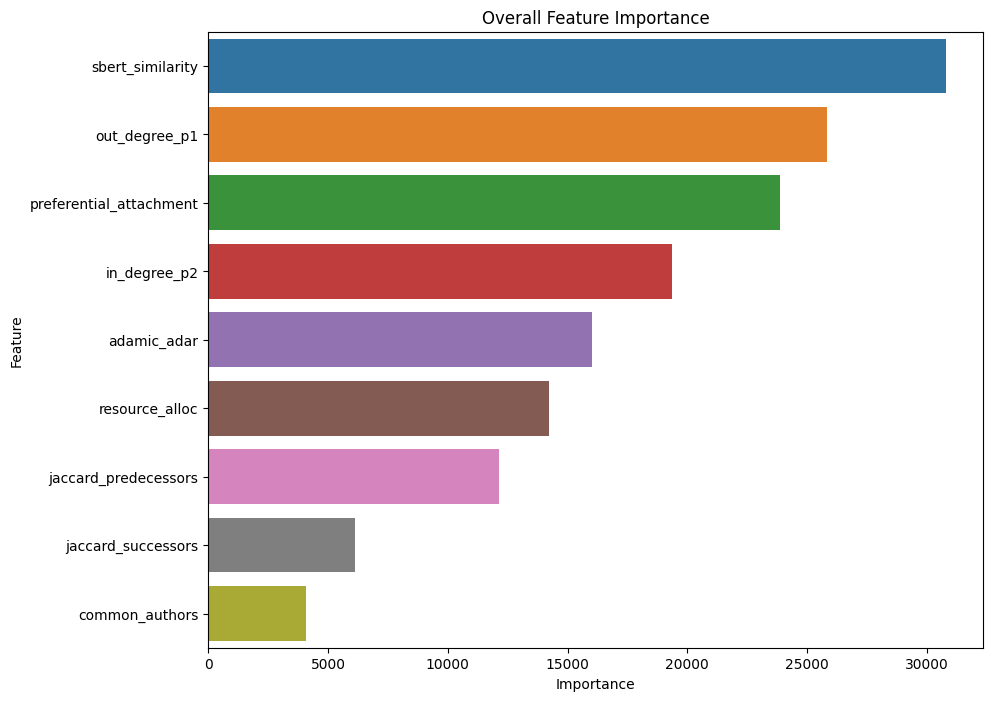


Using IDs from sample submission file: /kaggle/input/nlp-cse-uoi-2025/data_new/submission_random.csv

Submission file 'submission.csv' created. First 5 rows:
   ID     Label
0   0  0.998154
1   1  0.041430
2   2  0.629565
3   3  0.104054
4   4  0.058858

Script finished.


In [10]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

features_to_use = [
    'common_authors', 'sbert_similarity', 'out_degree_p1', 'in_degree_p2', 
    'preferential_attachment', 'jaccard_successors', 'jaccard_predecessors',
    'adamic_adar', 'resource_alloc'
]
X = pd.DataFrame()
y = pd.Series(dtype='int')
X_kaggle_test_final = pd.DataFrame()

if not df_train_features.empty:
    X = df_train_features[features_to_use]
    y = df_train_features['target']
    print(f"\nShape of X (training features): {X.shape}")

if not df_test_kaggle_features.empty:
    X_kaggle_test_final = df_test_kaggle_features[features_to_use]
    print(f"Shape of X_kaggle_test_final (Kaggle test features): {X_kaggle_test_final.shape}")

if not X.empty and not y.empty:
    print("\nStarting 5-Fold Cross-Validation Training...")
    
    N_SPLITS = 5
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    
    oof_preds = np.zeros((len(X),))
    test_preds = np.zeros((len(X_kaggle_test_final),))
    models = []
    feature_importances = pd.DataFrame(index=features_to_use)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n===== Fold {fold+1} =====")
        
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        lgbm_model = lgb.LGBMClassifier(
            objective='binary',
            metric='logloss',
            n_estimators=2500,
            learning_rate=0.01,
            num_leaves=80,
            max_depth=10,
            random_state=42 + fold,
            n_jobs=-1,
            colsample_bytree=0.7,
            subsample=0.7,
            reg_alpha=0.1,
            reg_lambda=0.1
        )
        
        lgbm_model.fit(X_train, y_train,
                       eval_set=[(X_val, y_val)],
                       eval_metric='logloss',
                       callbacks=[lgb.early_stopping(stopping_rounds=150, verbose=100)])
        
        val_preds = lgbm_model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = val_preds
        test_preds += lgbm_model.predict_proba(X_kaggle_test_final)[:, 1] / N_SPLITS
        
        models.append(lgbm_model)
        feature_importances[f'fold_{fold+1}'] = lgbm_model.feature_importances_

    from sklearn.metrics import log_loss
    oof_logloss = log_loss(y, oof_preds)
    print(f"\n\nOverall Out-of-Fold LogLoss: {oof_logloss:.5f}")
    
    feature_importances['mean'] = feature_importances.mean(axis=1)
    feature_importances.sort_values('mean', ascending=False, inplace=True)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='mean', y=feature_importances.index, data=feature_importances)
    plt.title('Overall Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

else:
    print("Training data is empty. Skipping model training.")

if len(test_preds) > 0 and not df_test_kaggle.empty:
    submission_ids = None 
    try:
        df_sample_sub = pd.read_csv(PATH_SAMPLE_SUBMISSION)
        if 'ID' in df_sample_sub.columns and len(df_sample_sub) == len(test_preds):
            submission_ids = df_sample_sub['ID']
            print(f"\nUsing IDs from sample submission file: {PATH_SAMPLE_SUBMISSION}")
        else:
             raise ValueError("Sample submission ID column not suitable or length mismatch.")
    except Exception as e:
        print(f"Warning: {e}. Defaulting to test set index for IDs.")
        if len(df_test_kaggle.index) == len(test_preds):
            submission_ids = df_test_kaggle.index
        else:
             print("ERROR: Length mismatch, cannot create submission IDs.")

    if submission_ids is not None:
        df_submission = pd.DataFrame({'ID': submission_ids, 'Label': test_preds})
        df_submission.to_csv('submission.csv', index=False)
        print("\nSubmission file 'submission.csv' created. First 5 rows:")
        print(df_submission.head())
    else:
        print("Could not create submission file due to ID issues.")
else:
    print("No predictions were generated. Submission file not created.")

print("\nScript finished.")